# Dataset
Our dataset, obtained from kaggle, contains a metadata-rich collection of conversations extracted from raw movie scripts. We are talking about 220,579 conversational exchanges between 10,292 pairs of movie characters involving 9,035 characters from 617 movies. This totals 304,713 utterances. 
In our project, we will be using the following files from the dataset: movie_lines.tsv, movie_conversations.tsv, movie_characters_metadata.tsv, movie_titles_metadata.tsv.

# Data Exploratory Analysis
Starting by eliminating duplicates

In [78]:
import pandas as pd
import sqlite3

dbfile = 'movie_lines.db'
con = sqlite3.connect(dbfile)
cursor = con.cursor()

# Read the data into a DataFrame
df_lines = pd.read_sql_query("SELECT * from lines", con)
df_movies = pd.read_sql_query("SELECT * from movies", con)
df_characters = pd.read_sql_query("SELECT * from characters", con)
df_conversations = pd.read_sql_query("SELECT * from conversations", con)
df_genres = pd.read_sql_query("SELECT * from genres", con)
df_movie_genre = pd.read_sql_query("SELECT * from movie_genre_linking", con)

# check how many rows and columns in each df
print(df_lines.shape)
print(df_movies.shape)
print(df_characters.shape)
print(df_conversations.shape)
print(df_genres.shape)
print(df_movie_genre.shape)

# remove duplicates for every df
df_lines.drop_duplicates(inplace=True)
df_movies.drop_duplicates(inplace=True)
df_characters.drop_duplicates(inplace=True)
df_conversations.drop_duplicates(inplace=True)
df_genres.drop_duplicates(inplace=True)
df_movie_genre.drop_duplicates(inplace=True)

# check how many rows and columns in each df
print(df_lines.shape)
print(df_movies.shape)
print(df_characters.shape)
print(df_conversations.shape)
print(df_genres.shape)
print(df_movie_genre.shape)



(304713, 6)
(617, 6)
(9035, 5)
(83097, 4)
(24, 2)
(1825, 2)
(304713, 6)
(617, 6)
(9035, 5)
(83097, 4)
(24, 2)
(1825, 2)


We can see that there is no duplicate data in the dataset.
## Dealing with missing data

In [10]:
# check how many null values in each df
print('Lines missing values: ', df_lines.isnull().sum())
print('Movies missing values: ', df_movies.isnull().sum())
print('Characters missing values: ', df_characters.isnull().sum())
print('Conversations missing values: ', df_conversations.isnull().sum())
print('Genres missing values: ', df_genres.isnull().sum())
print('Movie genre missing values: ', df_movie_genre.isnull().sum())



Lines missing values:  line_id            0
character_id       0
movie_id           0
conversation_id    0
line_sort          0
line_text          0
dtype: int64
Movies missing values:  movie_id          0
title             0
year              0
imdb_rating       0
imdb_votes        0
raw_script_url    0
dtype: int64
Characters missing values:  character_id       0
name               0
movie_id           0
gender          6020
age             6356
dtype: int64
Conversations missing values:  conversation_id    0
character1_id      0
character2_id      0
movie_id           0
dtype: int64
Genres missing values:  genre_id    0
name        0
dtype: int64
Movie genre missing values:  movie_id    0
genre_id    0
dtype: int64


We can see that the 'Characters' table has a lot of missing values for the 'gender' and 'age' columns. We are going to simply fill these with 'unkown' values.

In [12]:
df_characters.fillna('unknown', inplace=True)
print(df_characters.head())

   character_id      name  movie_id   gender      age
0             0    BIANCA         0        F      4.0
1             1     BRUCE         0  unknown  unknown
2             2   CAMERON         0        M      3.0
3             3  CHASTITY         0  unknown  unknown
4             4      JOEY         0        M      6.0


## Visualizing the data
Considering that this is a movie dataset, maybe it will be interesting to know the distribution of the IMDb rating of the movies in order to validate the quality of the dataset. Normally, the movies with the highest ratings are the ones that are most popular and have the most lines of dialogue.\
We can see that most of the movies have a rating higher than 6. In fact, in IMDb if the rating's above 7.5, it's safe to say that it's generally known as a good movie. So, we can say that the dataset is good enough to work with.

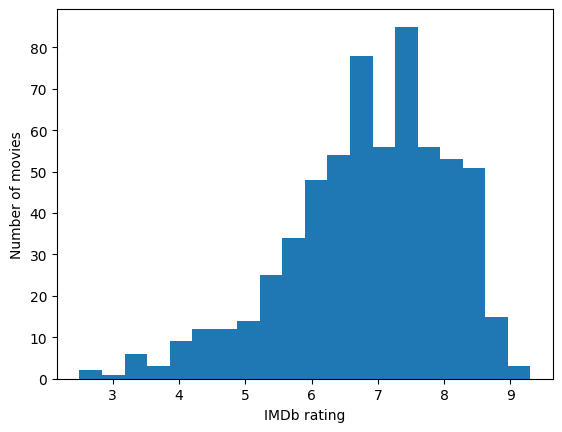

In [25]:
import matplotlib.pyplot as plt
plt.hist(df_movies['imdb_rating'], bins=20)
plt.ylabel('Number of movies')
plt.xlabel('IMDb rating')
plt.show()

However, if a movie has only 1 vote and it's 10, it doesn't mean that it's a good movie. So, we must check the distribution of the number of votes for each movie. The way we are going to do this is by plotting a pie chart where we group the movies by:
* 0-100 votes
* 100-1000 votes
* more than 1000 votes

We can see that the majority of the movies have more than 1000 votes, which provides us a good insight about the quality of the dataset.

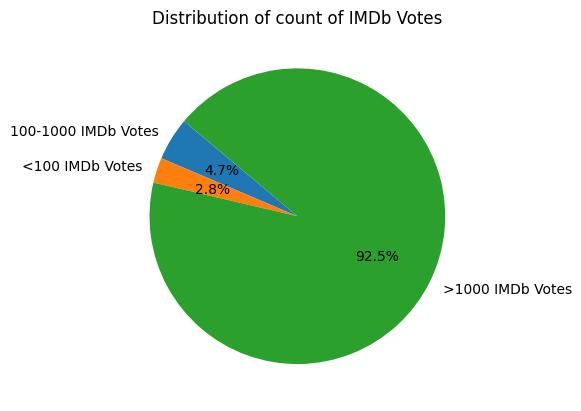

In [82]:
query = """
    SELECT
    CASE
        WHEN imdb_votes < 100 THEN '<100 IMDb Votes'
        WHEN imdb_votes >= 100 AND imdb_votes <= 1000 THEN '100-1000 IMDb Votes'
        ELSE '>1000 IMDb Votes'
    END AS vote_category,
    COUNT(*) AS movie_count
FROM movies
GROUP BY vote_category
ORDER BY vote_category;
"""

cursor.execute(query)
results = cursor.fetchall()

categories = [result[0] for result in results]
counts = [result[1] for result in results]

plt.pie(counts, labels=categories, autopct='%1.1f%%',startangle=140)
plt.title('Distribution of count of IMDb Votes')
plt.show()

Let's see if there is any relation between the IMDb rating and the number of lines of dialogue. We are going to plot a scatter plot where the x-axis is the number of lines of dialogue and the y-axis is the IMDb rating.\
As we can see, there doesn't appear to be any correlation between the number of lines of dialogue and the IMDb rating. This is a good thing because it means that the dataset is not biased towards the movies with the most lines of dialogue.

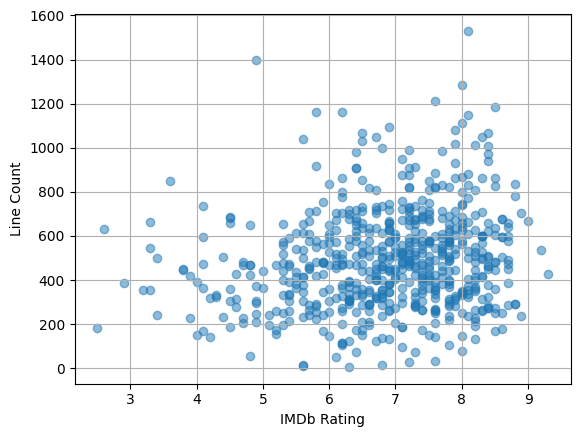

In [86]:
query = """
    SELECT
        m.imdb_rating AS imdb_rating,
        COUNT(l.line_id) AS line_count
    FROM movies m
    LEFT JOIN lines l ON m.movie_id = l.movie_id
    GROUP BY m.movie_id, m.imdb_rating
    ORDER BY imdb_rating;
"""
cursor.execute(query)
results = cursor.fetchall()

imdb_ratings = [result[0] for result in results]
line_counts = [result[1] for result in results]

plt.scatter(imdb_ratings, line_counts,alpha=0.5)
plt.xlabel('IMDb Rating')
plt.ylabel('Line Count')
plt.grid(True)
plt.show()

It could also be interesting to know which genres are the most popular in the dataset. 

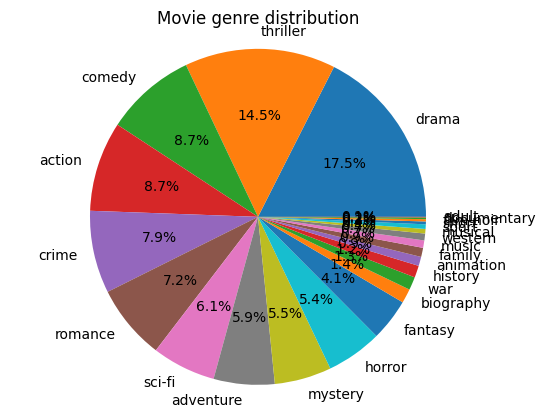

In [79]:
# group by genre_id and count the number of movies in each genre
genre_counts = df_movie_genre['genre_id'].value_counts().reset_index()
genre_counts.columns = ['genre_id', 'movie_count']

# merge with table genre
genre_counts = pd.merge(genre_counts, df_genres, on='genre_id', how='left')

plt.pie(genre_counts['movie_count'], labels=genre_counts['name'], autopct='%1.1f%%')
plt.title('Movie genre distribution')
plt.axis('equal')
plt.show()



Since we have a lot of genres overlapping, we will group them into one genre called 'other' and then plot the results.

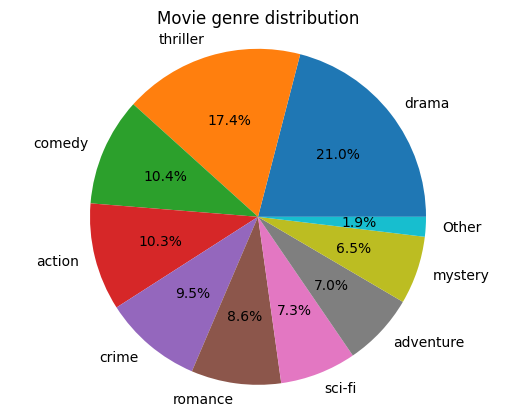

In [38]:
top_genres = genre_counts[genre_counts['movie_count'] >=100]
other_genres_count = genre_counts[genre_counts['movie_count'] <11]['movie_count'].sum()
other_genre_df = pd.DataFrame({'name':['Other'], 'movie_count':[other_genres_count]})
top_genres = pd.concat([top_genres, other_genre_df], ignore_index=True)

plt.pie(top_genres['movie_count'], labels=top_genres['name'], autopct='%1.1f%%')
plt.title('Movie genre distribution')
plt.axis('equal')
plt.show()


Now, it could be interesting to know which words are the most used in the dataset. We will use a wordcloud to visualize this.

In [62]:
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import string

#nltk.download('punkt') # uncomment this line if you haven't downloaded punkt before

text_data = ' '.join(df_lines['line_text'].astype(str))
tokens = word_tokenize(text_data)
word_freq = Counter(tokens)
most_common_words = word_freq.most_common(10)
for word,freq in most_common_words:
    print(word, freq)


. 334340
I 140815
you 111412
? 110240
the 88209
to 79343
a 66408
's 66342
n't 55093
... 50796


A lot of stop words.. Let's plot the results again without these...

In [67]:
#nltk.download('stopwords') # uncomment this line if you haven't downloaded stopwords before

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

tokens = [word.lower() for word in tokens if not word.lower() in stop_words and word not in string.punctuation and word.isalpha()]
word_freq = Counter(tokens)
most_common_words = word_freq.most_common(20)
for word,freq in most_common_words:
    print(word, freq)
    

know 21657
like 15003
get 14150
got 13308
want 11062
think 10781
one 10589
right 10027
go 9910
well 9865
going 8863
would 8292
see 8223
oh 7840
yes 7384
good 7326
could 7254
yeah 6968
tell 6835
come 6757


Finally, let's see which characters have the most lines of dialogue in the dataset.

In [85]:
query = """
    SELECT
        c.name AS character_name,
        m.title AS movie_title,
        COUNT(l.line_id) AS line_count
    FROM characters c
    JOIN lines l ON c.character_id = l.character_id
    JOIN movies m ON l.movie_id = m.movie_id
    GROUP BY c.name, m.title
    ORDER BY line_count DESC
    LIMIT 10;
"""

cursor.execute(query)
results = cursor.fetchall()
character_names = [result[0] for result in results]
line_counts = [result[1] for result in results]

for row in results:
    character_name, movie_title, line_count = row
    print(f"Character: {character_name}, Movie: {movie_title}, Lines: {line_count}")


Character: DANTE, Movie: clerks., Lines: 537
Character: BEN, Movie: the graduate, Lines: 489
Character: JOE, Movie: innerspace, Lines: 472
Character: ALVY, Movie: annie hall, Lines: 467
Character: ACE, Movie: casino, Lines: 465
Character: ENID, Movie: ghost world, Lines: 441
Character: MASON, Movie: chill factor, Lines: 436
Character: NIXON, Movie: nixon, Lines: 434
Character: GITTES, Movie: chinatown, Lines: 428
Character: ARLO, Movie: chill factor, Lines: 425
